# Exploratory Data Analysis

This notebook presents the final version of the Exploratory Data Analysis. It is divided into the following sections:

Exploratory Data Analysis
1. Import Libraries
2. Load Data 
3. General Transformations
4. Exploratory Data Analysis (EDA)  
    4.1 Coordinates Overview  
    4.2 Climate Attributes Analysis  
    4.3 Analysis of Early versus Late Decades  
    4.4 Time Series Analysis  
    4.5 Deep-dive into Snowfall, Temperature, and Precipitation Changes  

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import os
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load Data 

Load the data in a combined dataset creating an additional dimension for storing the dataset index.

In [72]:
# Import helper function
sys.path.append('.')
from helper import load_datasets

# Define file paths and load datasets
file_paths = [f"../data/00{i}_2006_2080_352_360.nc" for i in range(3, 9)]
datasets = load_datasets(file_paths)

# Print the size and shape of each dataset before combining
for file in file_paths:
    ds_temp = xr.open_dataset(file)
    print(f"Size of {file}: {ds_temp.nbytes / 1e6} MB, Shape: {ds_temp.sizes}")
    ds_temp.close()

# Read the .nc files into an xarray Dataset and add an index to distinguish the origin dataset
datasets = []
for i, file in enumerate(file_paths):
    ds_temp = xr.open_dataset(file)
    ds_temp = ds_temp.assign_coords(dataset_index=i)
    ds_temp = ds_temp.expand_dims('dataset_index')
    datasets.append(ds_temp)

# Combine the datasets along the 'time' dimension
ds = xr.concat(datasets, dim='time')

# Display the dataset
ds

Size of ../data/003_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of ../data/004_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of ../data/005_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of ../data/006_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of ../data/007_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of ../data/008_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})


<xarray.Dataset> Size: 2GB
Dimensions:        (dataset_index: 6, time: 164244, lat: 11, lon: 6)
Coordinates:
  * lat            (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon            (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * dataset_index  (dataset_index) int64 48B 0 1 2 3 4 5
  * time           (time) object 1MB 2006-01-02 00:00:00 ... 2080-12-31 00:00:00
Data variables:
    TREFMXAV_U     (dataset_index, time, lat, lon) float32 260MB nan nan ... nan
    FLNS           (dataset_index, time, lat, lon) float32 260MB 76.48 ... 75.48
    FSNS           (dataset_index, time, lat, lon) float32 260MB 44.47 ... 9.14
    PRECT          (dataset_index, time, lat, lon) float32 260MB 1.158e-08 .....
    PRSN           (dataset_index, time, lat, lon) float32 260MB 0.0 ... 1.98...
    QBOT           (dataset_index, time, lat, lon) float32 260MB 0.005241 ......
    TREFHT         (dataset_index, time, lat, lon) float32 260MB 284.4 ... 280.9
    UBOT           (dataset_index, time, lat, lon) float32 260MB 7.604 ... 7.6
    VBOT           (dataset_index, time, lat, lon) float32 260MB -3.69 ... 5.44

## 3. General Transformations

In [ ]:
# Transform Temperature variables from Kelvin to Celsius
ds['TREFMXAV_U'] = ds['TREFMXAV_U'] - 273.15
ds['TREFHT'] = ds['TREFHT'] - 273.15

# Create decade coord
ds = ds.assign_coords(decade=(ds['time'].dt.year // 10) * 10)

In [ ]:
def convert_longitude_360_to_180(lon_360):
    """Converts longitude from 0-360 to -180 to 180 range."""
    lon_180 = lon_360
    if lon_360 > 180:
        lon_180 = lon_360 - 360
    return lon_180

## 4. Exploratory Data Analysis (EDA)

### 4.1 Coordinates Overview

In [73]:
# Select the first 3 time steps of the first dataset, and inspect their format
np.unique(ds.isel(time=slice(0,3), dataset_index=0)['time'])

array([cftime.DatetimeNoLeap(2006, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 4, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

Identify Coordinates Information

In [ ]:
# Convert the DataArray to a pandas Series
lat_series = ds["lat"].to_series()
lon_series = ds["lon"].to_series()

# Get unique values
unique_lat = len(lat_series)
unique_lon = len(lon_series)

print("Unique Lat:", unique_lat)
print("Unique Lon:", unique_lon)    

Unique Lat: 11
Unique Lat: 6


In [75]:
# Check coordinate values
print("\nLatitude range:", ds.lat.values.min(), "to", ds.lat.values.max())
print("Longitude range:", ds.lon.values.min(), "to", ds.lon.values.max())
print("Time period:", ds.time.values[0], "to", ds.time.values[-1])


Latitude range: 49.47644 to 58.900524
Longitude range: 352.5 to 358.75
Time period: 2006-01-02 00:00:00 to 2080-12-31 00:00:00


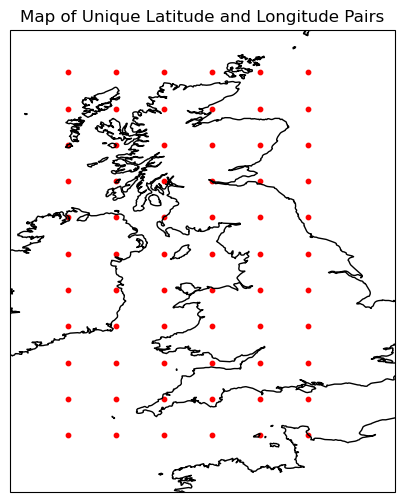

In [77]:
# Extract unique pairs of latitude and longitude
unique_lat_lon_pairs = ds[['lat', 'lon']].to_dataframe().drop_duplicates().reset_index()
unique_lat_lon_pairs['count'] = 1

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-9, 1, 48, 60], crs=ccrs.PlateCarree())  # Set extent to focus on the UK
ax.coastlines()

# Plot the unique latitude and longitude pairs
ax.scatter(unique_lat_lon_pairs['lon'], unique_lat_lon_pairs['lat'], color='red', s=10, transform=ccrs.PlateCarree())

# Set the title of the plot
ax.set_title('Map of Unique Latitude and Longitude Pairs')
# Save the plot
plt.savefig('plots/map-of-unique-lat-and-long-pairs', dpi=200)
# Show the plot
plt.show()


### 4.2 Climate Attributes Analysis

First, the mean temperature values from the first dataset are plotted on the map.

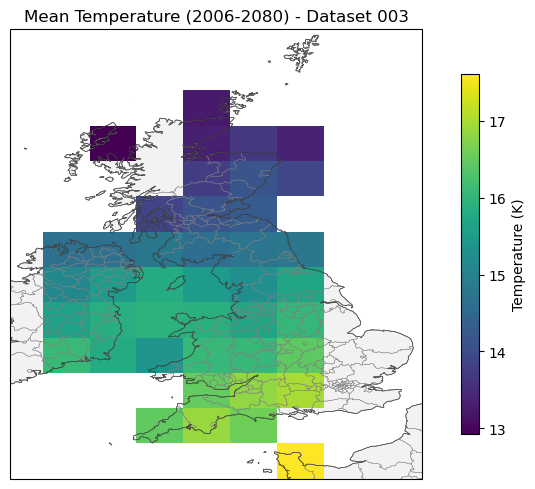

In [ ]:
# Select first dataset
dataset_idx = 0  
ds_single = ds.sel(dataset_index=dataset_idx)

# Create figure and axis
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Natural Earth features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                              name='admin_1_states_provinces',
                                              scale='10m',
                                              facecolor='none')

# Set extent for the UK
ax.set_extent([-9, 2, 49, 61], ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f2f2f2')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(states_provinces, edgecolor='gray', linewidth=0.3)

# Calculate mean temperature across time
temp = ds_single.TREFMXAV_U.mean(dim='time')

# Add the temperature data on top of the map
mesh = ax.pcolormesh(
    temp.lon, temp.lat, temp.values,
    cmap='viridis',
    transform=ccrs.PlateCarree(),
    shading='auto'
)

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, pad=0.05, shrink=0.8)
cbar.set_label('Temperature (K)')

# Add title
plt.title(f'Mean Temperature (2006-2080) - Dataset {int(dataset_idx)}')

plt.tight_layout()
plt.savefig('plots/mean-TREFMXAV-U-dataset-1.png', dpi=300)
plt.show()

Next, the mean TREFMXAV_U values by decade are plotted on the map, using one of the datasets.

C:\Users\rebec\AppData\Local\Temp\ipykernel_22204\917820585.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


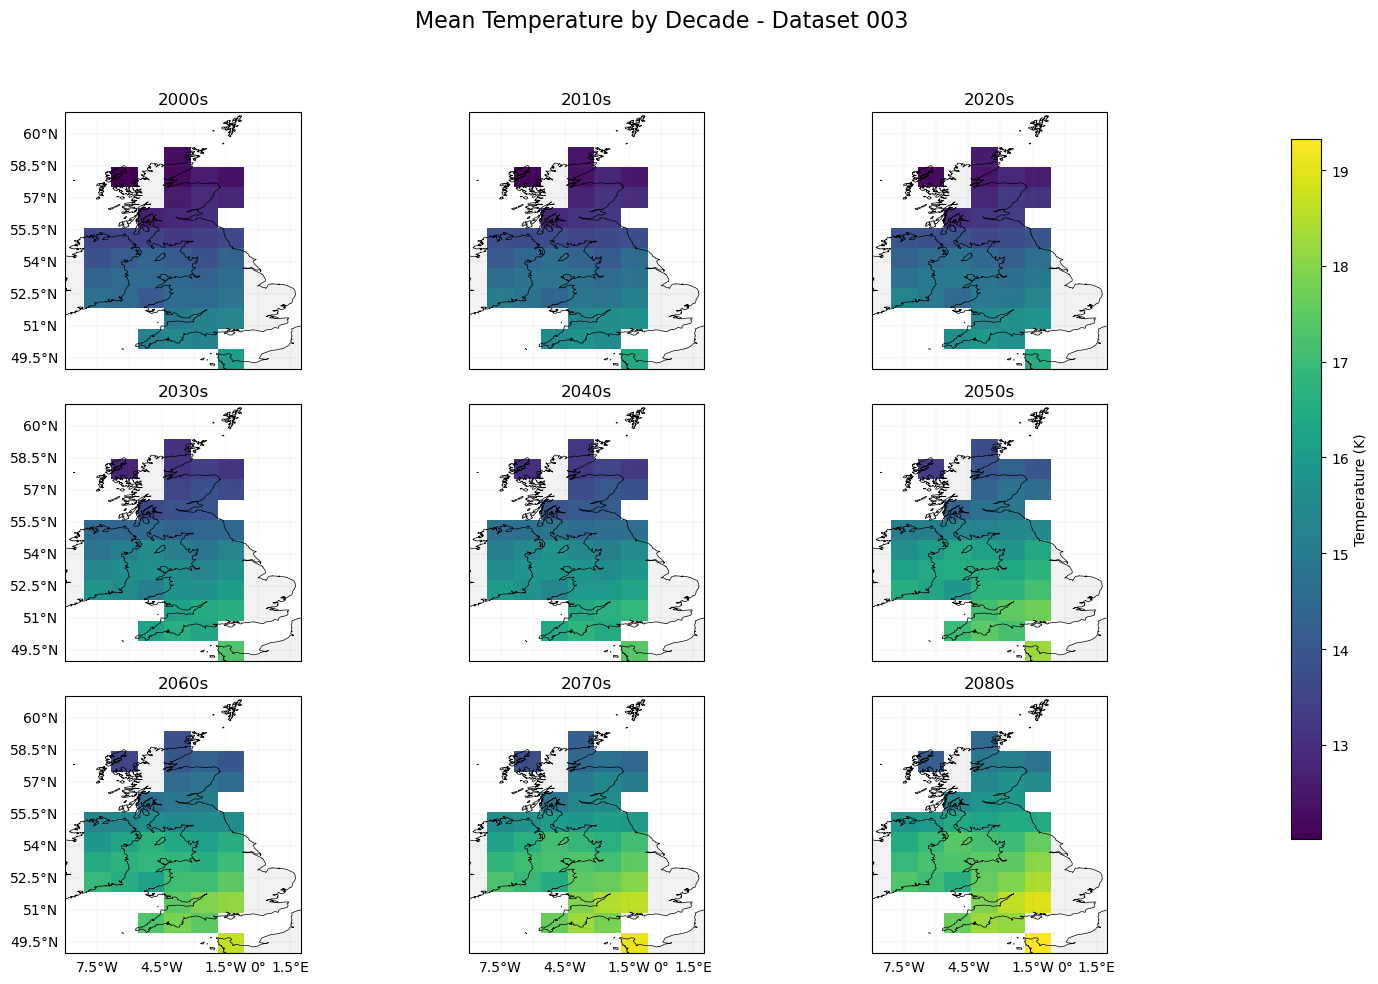

In [ ]:
# Select dataset 1 (index 0)
dataset_idx = 0
ds_single = ds.sel(dataset_index=dataset_idx)

# Get unique decades
decades = sorted(np.unique(ds_single.decade.values))

# Create a dictionary to store data for each decade
decade_data_dict = {}

# Calculate mean temperature for each decade once
for decade in decades:
    decade_data_dict[decade] = ds_single.where(ds_single.decade == decade).TREFMXAV_U.mean(dim='time')

# Find global min/max temperature for consistent color scale
all_valid_values = np.concatenate([arr.values[~np.isnan(arr.values)] for arr in decade_data_dict.values()])
vmin, vmax = np.min(all_valid_values), np.max(all_valid_values)

# Set up the figure layout
n_decades = len(decades)
n_cols = 3
n_rows = (n_decades + n_cols - 1) // n_cols
fig = plt.figure(figsize=(15, 10))

# Create the plots
for i, decade in enumerate(decades):
    # Get the pre-calculated data
    decade_data = decade_data_dict[decade]
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, i+1, projection=ccrs.PlateCarree())
    
    # Add map features and data
    ax.set_extent([-9, 2, 49, 61], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='#f2f2f2')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Plot the data
    mesh = ax.pcolormesh(
        decade_data.lon, decade_data.lat, decade_data.values,
        cmap='viridis', vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(), shading='auto'
    )
    
    # Add title and gridlines
    ax.set_title(f'{decade}s')
    gl = ax.gridlines(linewidth=0.3, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = (i >= (n_rows-1)*n_cols)
    gl.left_labels = (i % n_cols == 0)

# Add colourbar and title
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Temperature (K)')

fig.suptitle(f'Mean Temperature by Decade - Dataset {int(dataset_idx)}', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('plots/temperature-by-decade-dataset_1.png', dpi=300)
plt.show()

Finally, the mean TREFMXAV_U and PRSN values across all datasets are plotted by decade.

C:\Users\rebec\AppData\Local\Temp\ipykernel_22204\2945709752.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


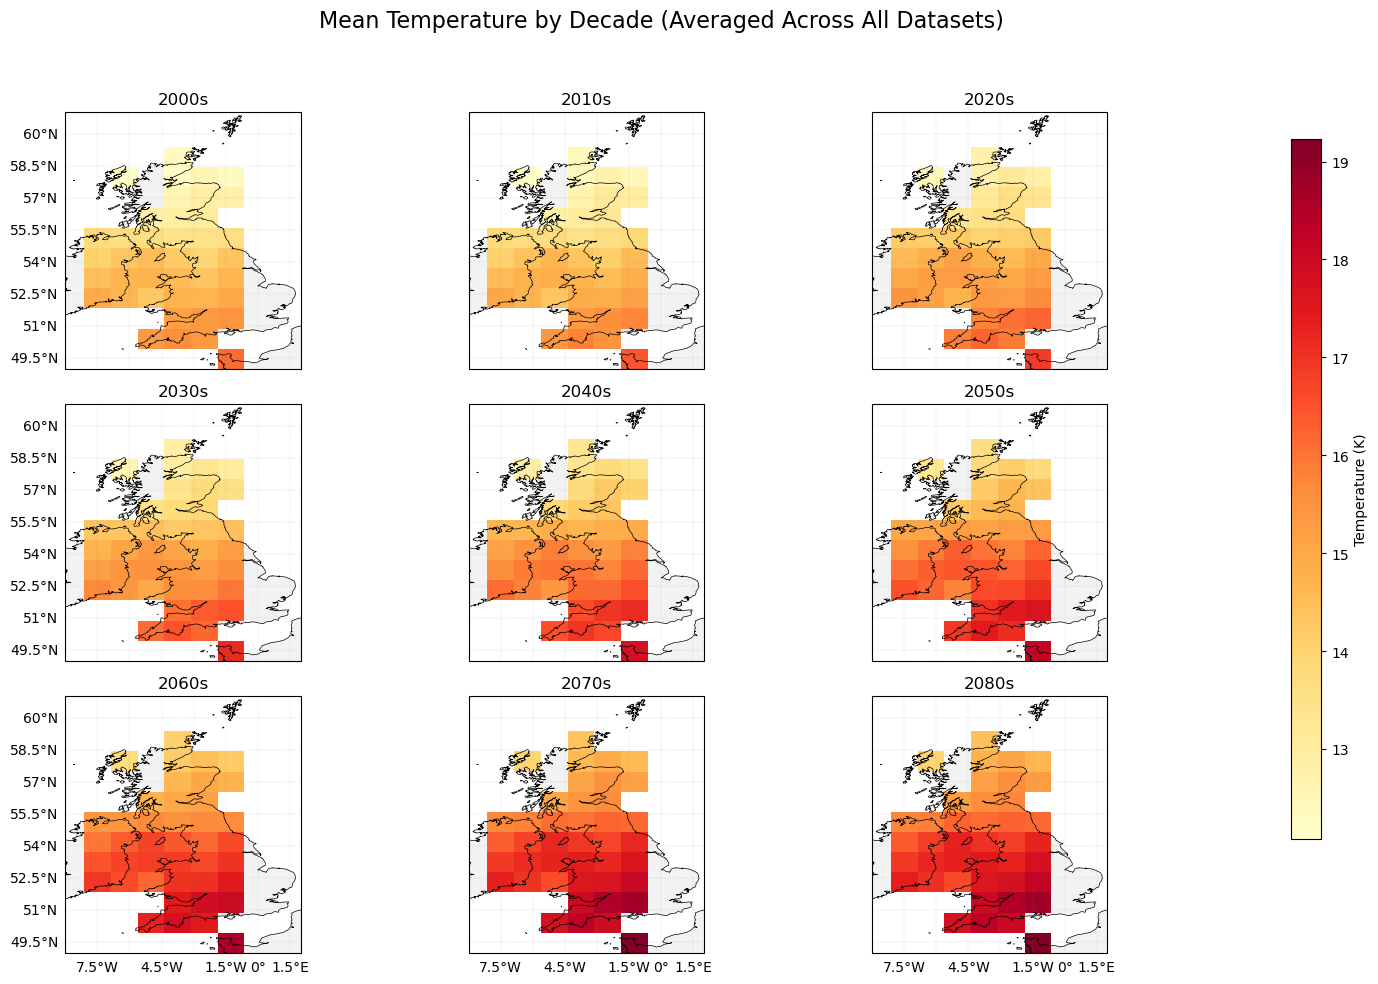

In [ ]:
# Get unique decades
decades = sorted(np.unique(ds.decade.values))

# Create a multi-panel figure - one panel per decade
fig = plt.figure(figsize=(15, 10))

# Calculate how many rows and columns are needed for the subplots
n_decades = len(decades)
n_cols = 3 
n_rows = (n_decades + n_cols - 1) // n_cols

# Store decade data to find global min/max
all_decade_data = []

# First calculate all the decade means
for i, decade in enumerate(decades):
    # Select data for this decade across all datasets
    decade_data = ds.where(ds.decade == decade).TREFMXAV_U.mean(dim=['time', 'dataset_index'])
    all_decade_data.append(decade_data)

# Find global min/max for consistent color scale
valid_data = np.concatenate([d.values[~np.isnan(d.values)].flatten() for d in all_decade_data])
vmin, vmax = np.min(valid_data), np.max(valid_data)

# Now create the plots
for i, decade in enumerate(decades):
    decade_data = all_decade_data[i]
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, i+1, projection=ccrs.PlateCarree())
    
    # Set extent for the UK
    ax.set_extent([-9, 2, 49, 61], ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='#f2f2f2')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Add the temperature data
    mesh = ax.pcolormesh(
        decade_data.lon, decade_data.lat, decade_data.values,
        cmap='YlOrRd',
        vmin=vmin, vmax=vmax,  
        transform=ccrs.PlateCarree(),
        shading='auto'
    )
    
    # Add title for each decade
    ax.set_title(f'{decade}s')
    
    # Add gridlines
    gl = ax.gridlines(linewidth=0.3, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = (i >= (n_rows-1)*n_cols) 
    gl.left_labels = (i % n_cols == 0)  

# Add colourbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Temperature (K)')

# Add title
fig.suptitle('Mean Temperature by Decade (Averaged Across All Datasets)', fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('plots/temperature-by-decade-averaged-across-all-datasets.png', dpi=300)
plt.show()

In [ ]:
# PRSN
# Get unique decades
decades = sorted(np.unique(ds.decade.values))

# Create a multi-panel figure - one panel per decade
fig = plt.figure(figsize=(15, 10))

# Calculate how many rows and columns we need for the subplots
n_decades = len(decades)
n_cols = 3  # You can adjust this
n_rows = (n_decades + n_cols - 1) // n_cols

# Conversion factor for PRSN: m/s to mm/day
conversion_factor = 86400 * 1000  # seconds in a day * 1000 to convert m to mm

# Store decade data to find global min/max
all_decade_data = []

# First calculate all the decade means
for i, decade in enumerate(decades):
    # Select data for this decade across all datasets and apply conversion
    decade_data = ds.where(ds.decade == decade).PRSN.mean(dim=['time', 'dataset_index']) * conversion_factor
    all_decade_data.append(decade_data)

# Find global min/max for consistent color scale
valid_data = np.concatenate([d.values[~np.isnan(d.values)].flatten() for d in all_decade_data])
vmin, vmax = np.min(valid_data), np.max(valid_data)

# Now create the plots
for i, decade in enumerate(decades):
    decade_data = all_decade_data[i]
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, i+1, projection=ccrs.PlateCarree())
    
    # Set extent for the UK
    ax.set_extent([-9, 2, 49, 61], ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='#f2f2f2')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Add the snowfall data
    mesh = ax.pcolormesh(
        decade_data.lon, decade_data.lat, decade_data.values,
        cmap='Blues',  # Blues is a good colormap for snowfall
        vmin=vmin, vmax=vmax,  # Use consistent color scale
        transform=ccrs.PlateCarree(),
        shading='auto'
    )
    
    # Add title for each decade
    ax.set_title(f'{decade}s')
    
    # Add minimal gridlines
    gl = ax.gridlines(linewidth=0.3, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = (i >= (n_rows-1)*n_cols)  # Only bottom row gets labels
    gl.left_labels = (i % n_cols == 0)  # Only leftmost column gets labels

# Add colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Snowfall (mm/day water equivalent)')

# Add overall title
fig.suptitle('Mean Snowfall by Decade (Averaged Across All Datasets)', fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('plots/snowfall_by_decade_all_datasets.png', dpi=300)
plt.show()

### 4.3 Analysis of Early versus Late Decades

In this step, a comparison table was created to understand the gap between early future decade (2030) with the later future decade (2070), calculating changes and mean values for each dataset.

- Average change (%): This value represents the average percentage change between the early and late decades.

- Delta std: This value refers to the standard deviation between the deltas of each dataset. 

In [82]:
# List of attributes to process
attributes = ['TREFHT','TREFMXAV_U', 'FLNS', 'FSNS','PRECT','PRSN','QBOT','UBOT','VBOT']  # Replace with actual attribute names

# Dictionary to store results for each attribute
results = pd.DataFrame()

for attribute in attributes:

    # Group data by decade and compute the mean value for the attribute
    mean_by_decade = ds[attribute].groupby(['decade', 'dataset_index']).mean()

    # Convert the result to a DataFrame for easier inspection
    mean_by_decade_df = mean_by_decade.to_dataframe().reset_index()
    mean_by_decade_df = mean_by_decade_df.groupby(['decade', 'dataset_index'])[attribute].mean()

    temp_early_dec = mean_by_decade_df[mean_by_decade_df.index.isin([(2030,)])]
    temp_early_dec = temp_early_dec.reset_index()
    temp_early_dec['period'] = 'early'

    temp_lat_dec = mean_by_decade_df[mean_by_decade_df.index.isin([(2070,)])]
    temp_lat_dec = temp_lat_dec.reset_index()
    temp_lat_dec['period'] = 'later'

    combined_temp = pd.concat([temp_lat_dec, temp_early_dec])

    # Create a pivot table
    pivot_table = combined_temp.pivot_table(index='dataset_index', columns='period', values=attribute)

    # Calculate the delta between 'later' and 'early' periods
    pivot_table['delta'] = pivot_table['later'] - pivot_table['early']

    # Calculate the standard deviation for the deltas
    delta_std = pivot_table['delta'].std()

    # Calculate the average change in percentage
    pivot_table['percent_change'] = (pivot_table['delta'] / pivot_table['early']) * 100
    average_percent_change = pivot_table['percent_change'].mean()

    pivot_table['attribute'] = attribute
    pivot_table = pivot_table[['attribute', 'early', 'later', 'delta']]
    results = pd.concat([results, pivot_table])
    
    # Display results for each attribute
    print(attribute)
    print("Average change (%)", average_percent_change)
    print("Delta std:", delta_std)
    display(pivot_table[['early', 'later', 'delta']])

TREFHT
Average change (%) 0.5575621
Delta std: 0.14695051


period              early       later     delta
dataset_index                                  
0              285.061035  286.371124  1.310089
1              285.022064  286.616852  1.594788
2              284.867432  286.517334  1.649902
3              285.289062  286.860870  1.571808
4              284.723633  286.438354  1.714722
5              284.681152  286.371826  1.690674

TREFMXAV_U
Average change (%) 11.867394
Delta std: 0.12668422


period             early      later     delta
dataset_index                                
0              14.956687  16.507235  1.550548
1              14.932655  16.694687  1.762032
2              14.831085  16.552017  1.720932
3              15.175507  16.965164  1.789658
4              14.596094  16.533541  1.937447
5              14.635066  16.445021  1.809955

FLNS
Average change (%) -1.7366601
Delta std: 0.7102481


period             early      later     delta
dataset_index                                
0              48.653706  48.010216 -0.643490
1              48.392082  47.973248 -0.418835
2              49.230507  47.830647 -1.399860
3              48.792885  48.496208 -0.296677
4              48.664394  48.343655 -0.320740
5              49.387173  47.351795 -2.035378

FSNS
Average change (%) 2.7590864
Delta std: 1.7335935


period              early       later     delta
dataset_index                                  
0              110.073502  113.086197  3.012695
1              108.564651  112.965591  4.400940
2              111.140800  112.321548  1.180748
3              110.161255  114.585670  4.424416
4              108.929283  113.400360  4.471077
5              110.447517  111.088684  0.641167

PRECT
Average change (%) 3.1185694
Delta std: 1.4836579e-09


period                early         later         delta
dataset_index                                          
0              4.063637e-08  3.913149e-08 -1.504876e-09
1              3.908783e-08  4.102685e-08  1.939021e-09
2              3.917289e-08  4.212128e-08  2.948386e-09
3              3.902127e-08  4.038450e-08  1.363230e-09
4              3.987365e-08  4.099280e-08  1.119151e-09
5              3.956934e-08  4.100456e-08  1.435225e-09

PRSN
Average change (%) -72.881645
Delta std: 8.946536e-11


period                early         later         delta
dataset_index                                          
0              2.878646e-10  1.073061e-10 -1.805585e-10
1              1.916264e-10  7.439595e-11 -1.172304e-10
2              2.932911e-10  6.415467e-11 -2.291364e-10
3              2.235494e-10  6.525711e-11 -1.582923e-10
4              3.642794e-10  7.709695e-11 -2.871825e-10
5              4.201418e-10  6.041805e-11 -3.597238e-10

QBOT
Average change (%) 10.4367485
Delta std: 8.598304e-05


period            early     later     delta
dataset_index                              
0              0.006673  0.007223  0.000550
1              0.006620  0.007373  0.000754
2              0.006536  0.007315  0.000780
3              0.006775  0.007420  0.000645
4              0.006546  0.007209  0.000663
5              0.006488  0.007229  0.000740

UBOT
Average change (%) 23.281479
Delta std: 0.22715972


period            early     later     delta
dataset_index                              
0              1.924237  2.351543  0.427306
1              2.259040  2.303131  0.044091
2              1.974287  2.350199  0.375912
3              1.877999  2.529079  0.651079
4              1.914953  2.497457  0.582504
5              1.977635  2.598666  0.621031

VBOT
Average change (%) 8.693405
Delta std: 0.14242493


period            early     later     delta
dataset_index                              
0              1.597471  1.611159  0.013688
1              1.608923  1.738189  0.129266
2              1.690744  1.647537 -0.043207
3              1.717225  1.798113  0.080888
4              1.414130  1.722747  0.308617
5              1.470050  1.753632  0.283581

Overall, there are no significant differences in the mean values between the two decades of interest. Although some variables such as snow and temperature show significant changes.  

 Following this, we plot the difference in TREFMXAV_U between an early period (2000-2030), and a late period (2050-2080).

Actual temperature change range: 1.37K to 2.25K


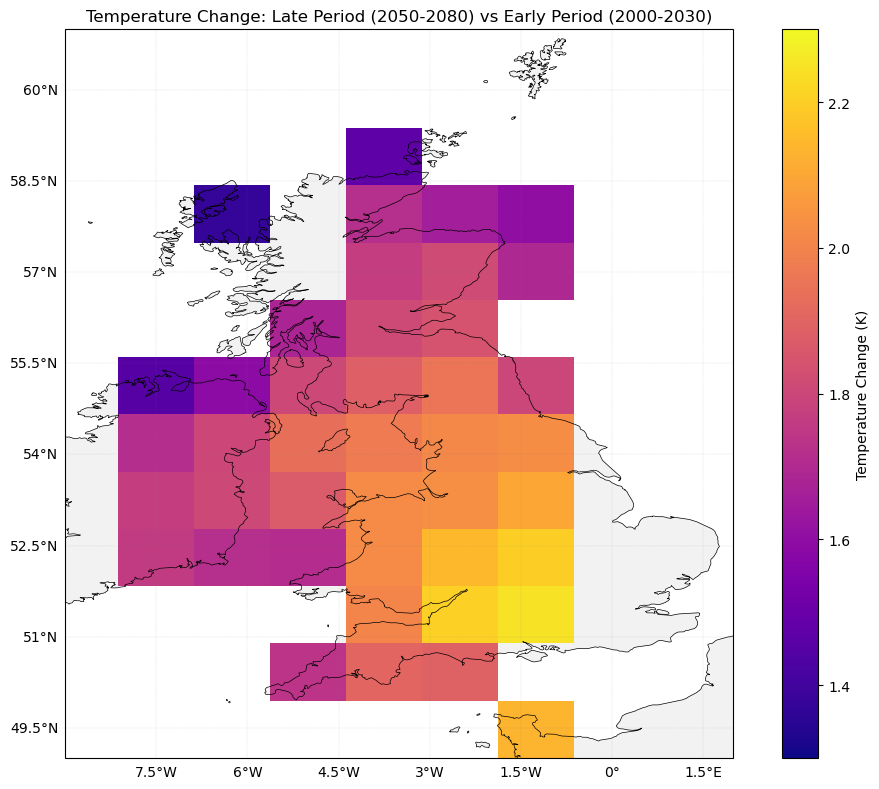

In [ ]:
# Select early and late periods
early_period = ds.where((ds.decade >= 2000) & (ds.decade < 2030)).TREFMXAV_U.mean(dim=['time', 'dataset_index'])
late_period = ds.where((ds.decade >= 2050) & (ds.decade <= 2080)).TREFMXAV_U.mean(dim=['time', 'dataset_index'])

# Calculate difference
difference = late_period - early_period

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set extent for the UK
ax.set_extent([-9, 2, 49, 61], ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f2f2f2')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Find the actual min and max of the difference data
actual_min = np.nanmin(difference.values)
actual_max = np.nanmax(difference.values)
print(f"Actual temperature change range: {actual_min:.2f}K to {actual_max:.2f}K")

# Round to nearest 0.1K for cleaner limits
vmin = np.floor(actual_min * 10) / 10
vmax = np.ceil(actual_max * 10) / 10

# Plot the temperature difference with adjusted colormap and range
mesh = ax.pcolormesh(
    difference.lon, difference.lat, difference.values,
    cmap='plasma', 
    vmin=vmin, vmax=vmax, 
    transform=ccrs.PlateCarree(),
    shading='auto'
)

# Add gridlines
gl = ax.gridlines(linewidth=0.3, color='gray', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, pad=0.05)
cbar.set_label('Temperature Change (K)')

# Add title
plt.title('Temperature Change: Late Period (2050-2080) vs Early Period (2000-2030)')

# Save and display
plt.tight_layout()
plt.savefig('plots/temperature-change-early-vs-late-period.png', dpi=300)
plt.show()

### 4.4 Time Series Analysis

Following the previous analysis, a decadal time series analysis for each variable and dataset is conducted below.

The chart on the left shows the decadal mean values for each dataset, while the chart on the right displays the overall decadal mean value with 95% confidence intervals.

TREFHT


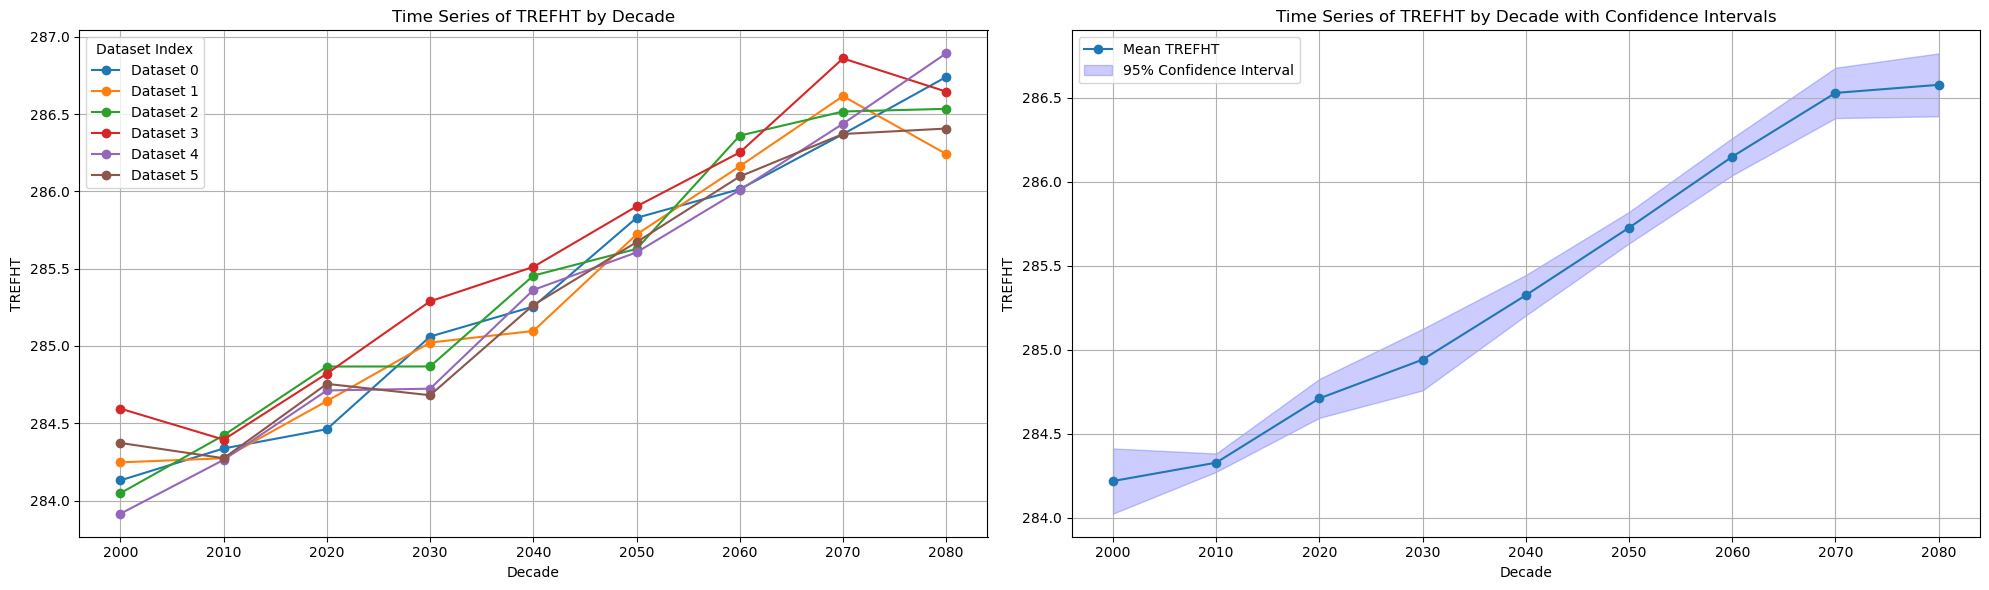

TREFMXAV_U


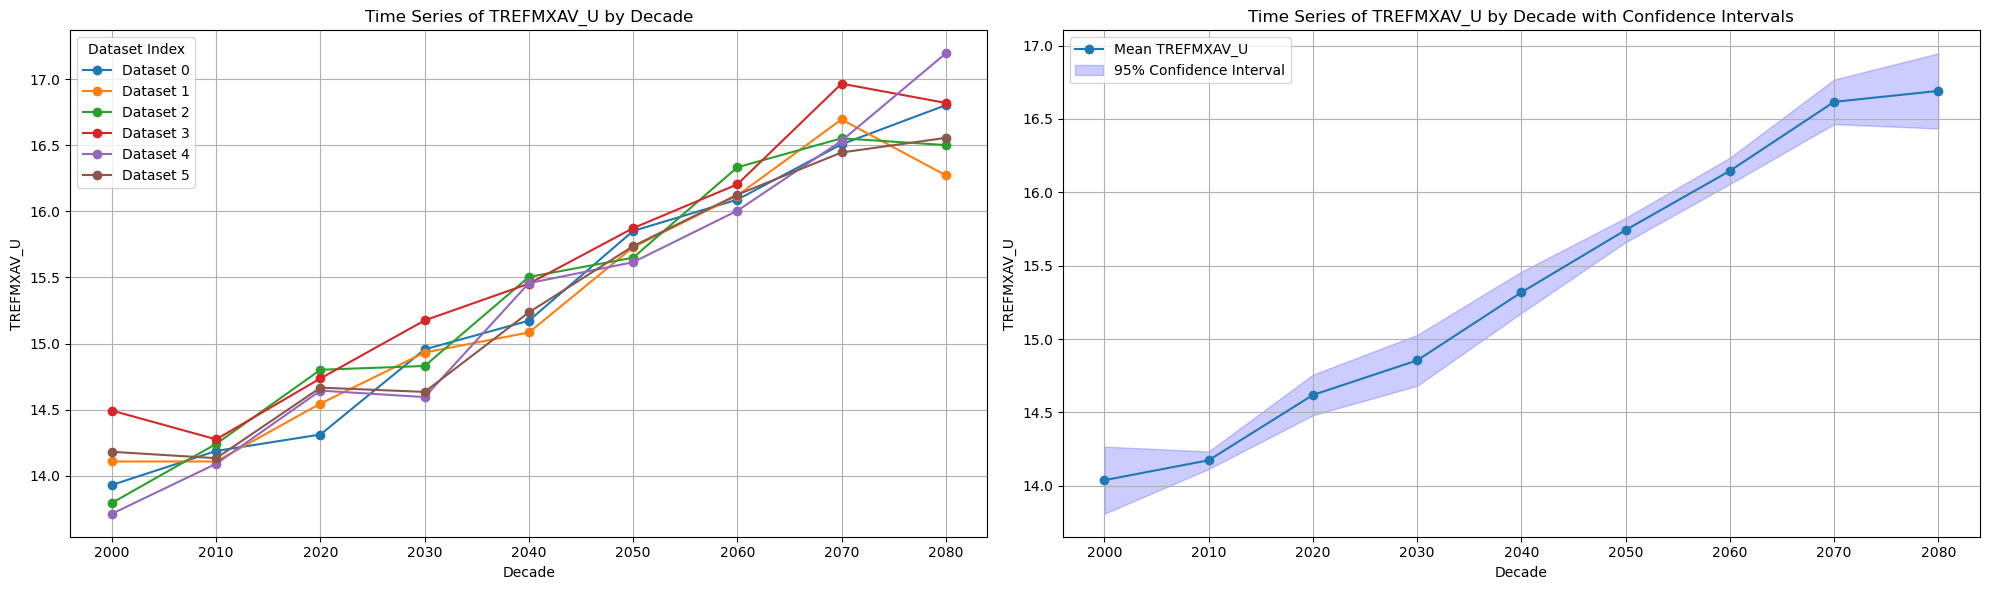

FLNS


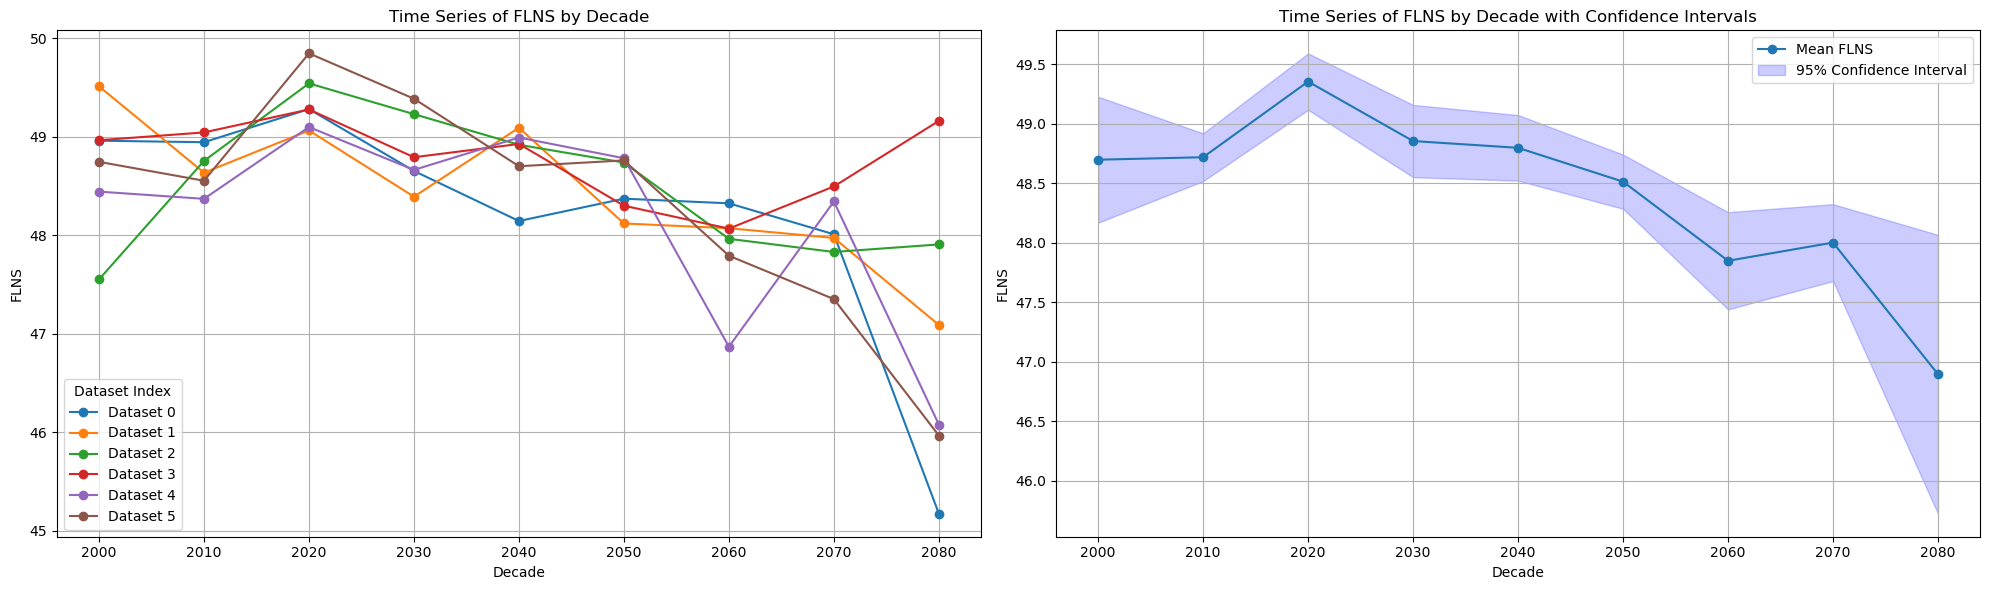

FSNS


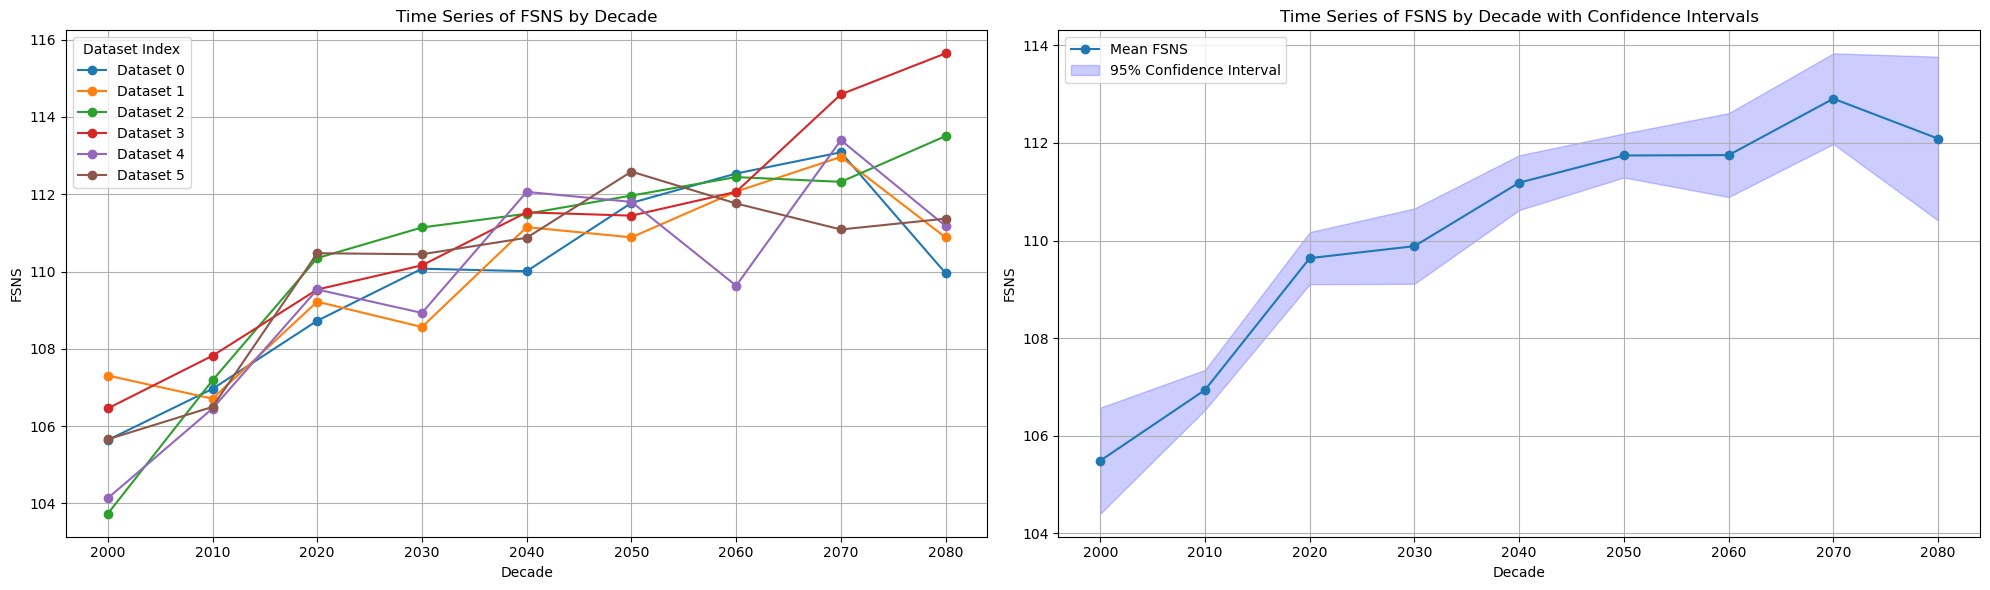

PRECT


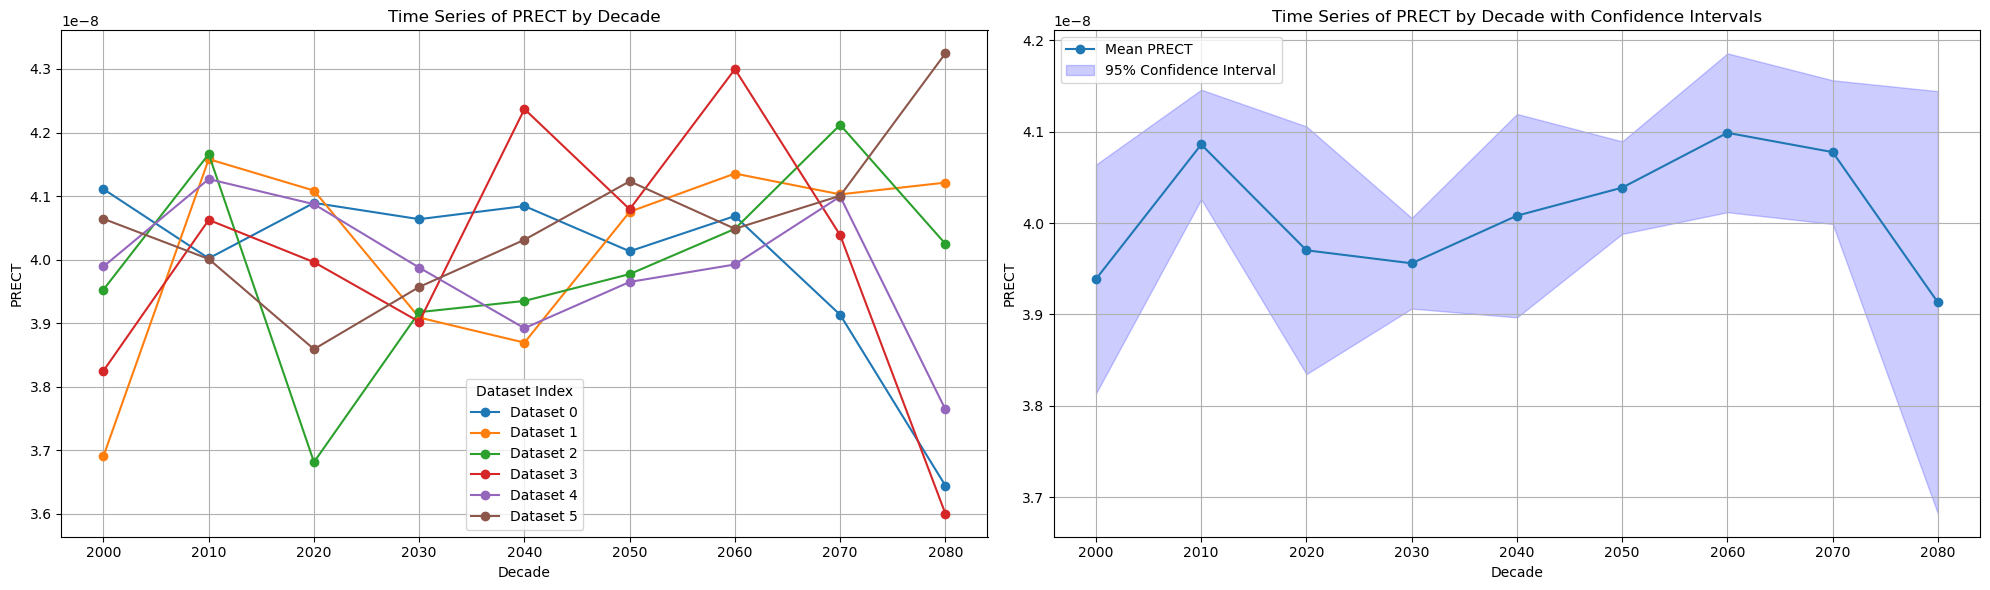

PRSN


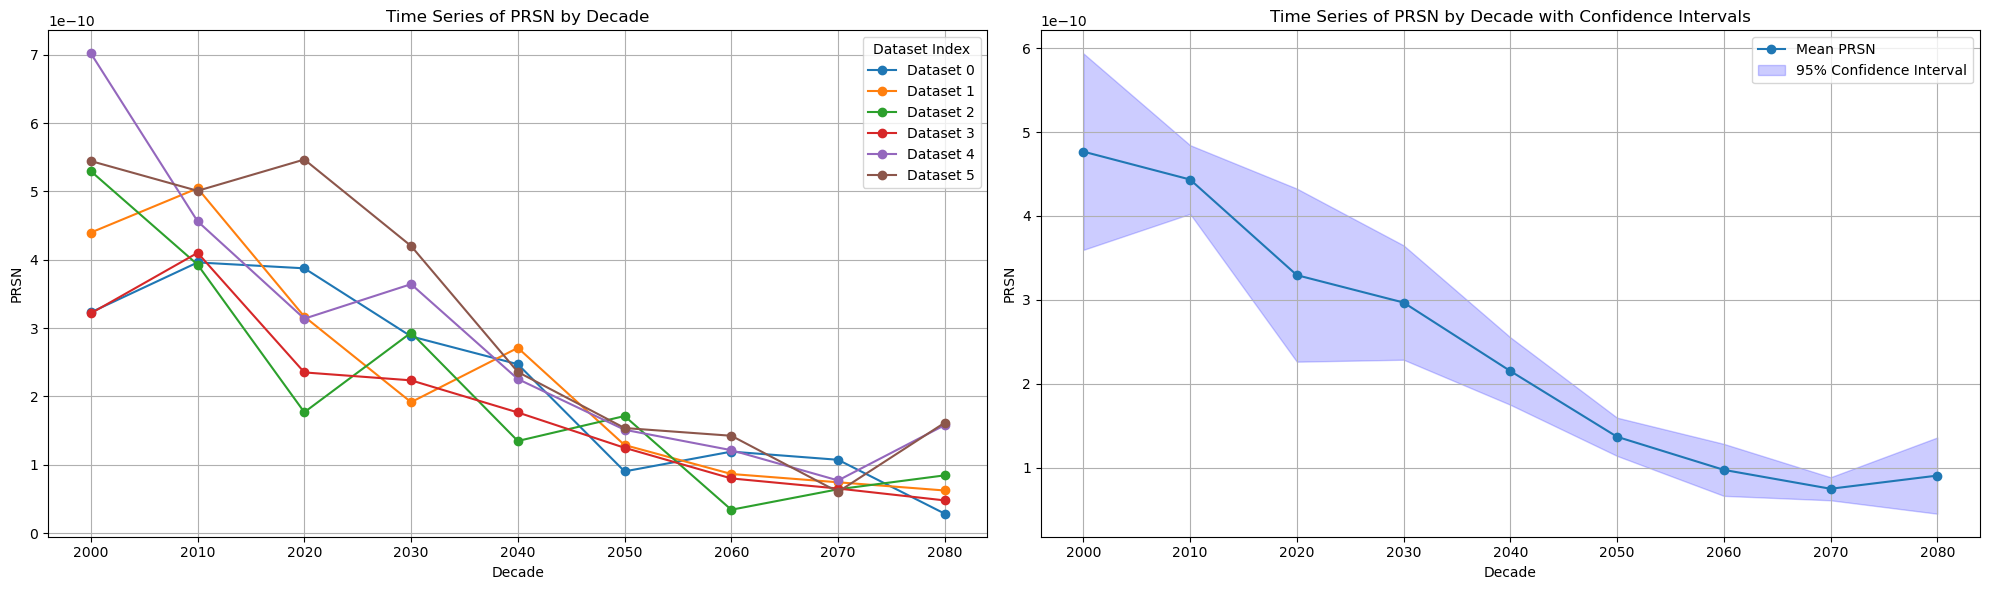

QBOT


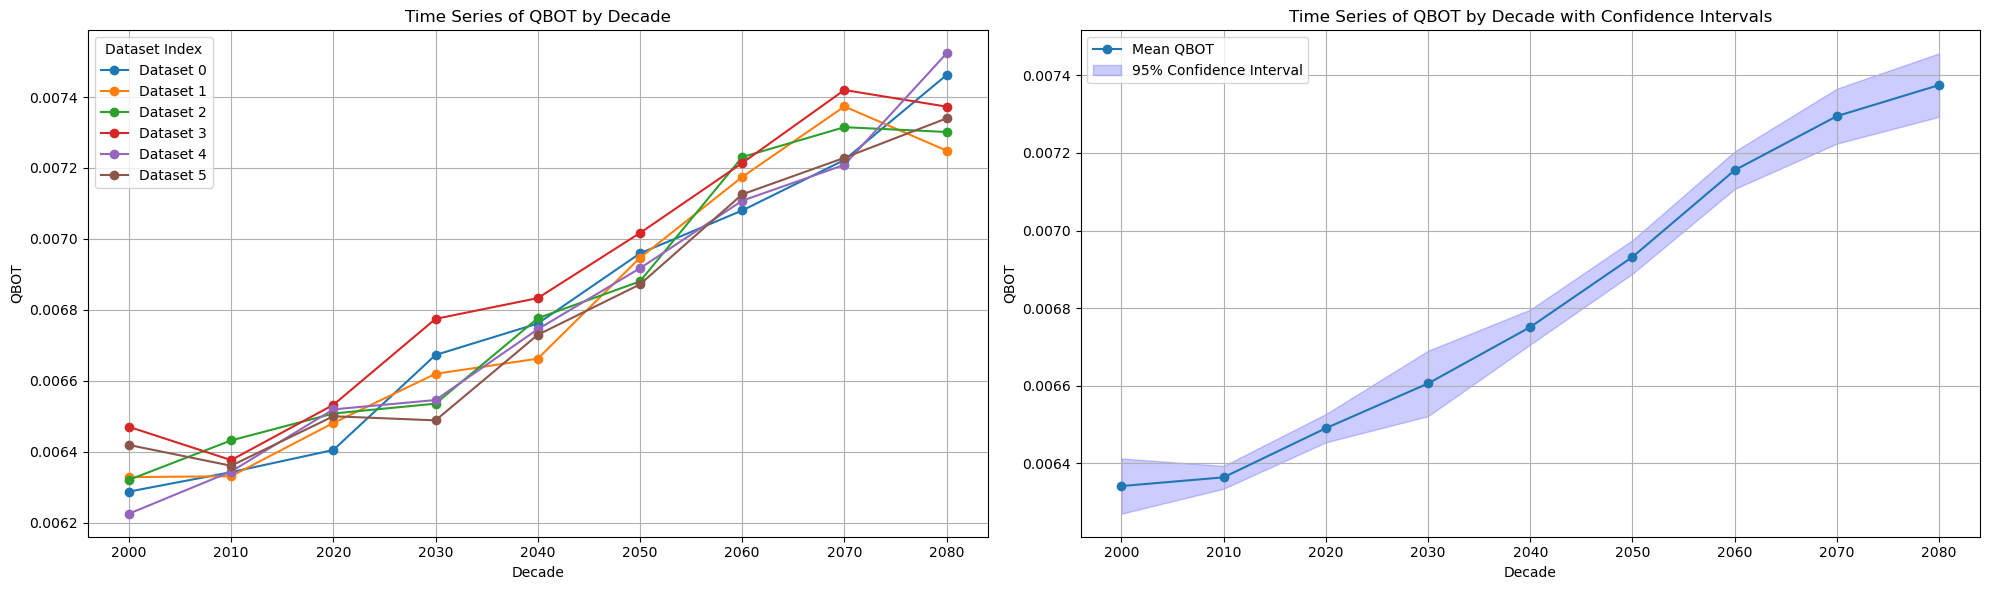

UBOT


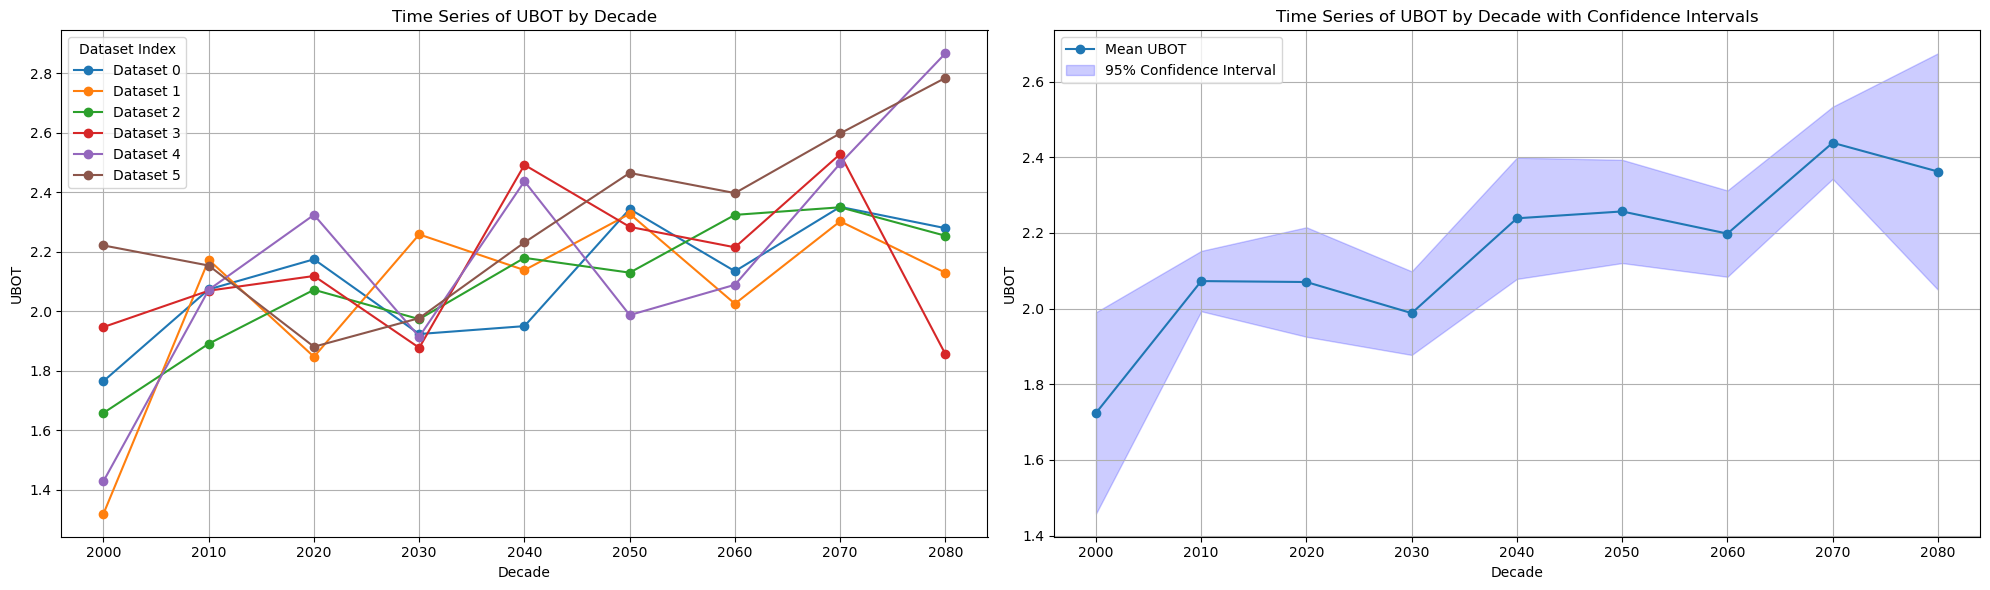

VBOT


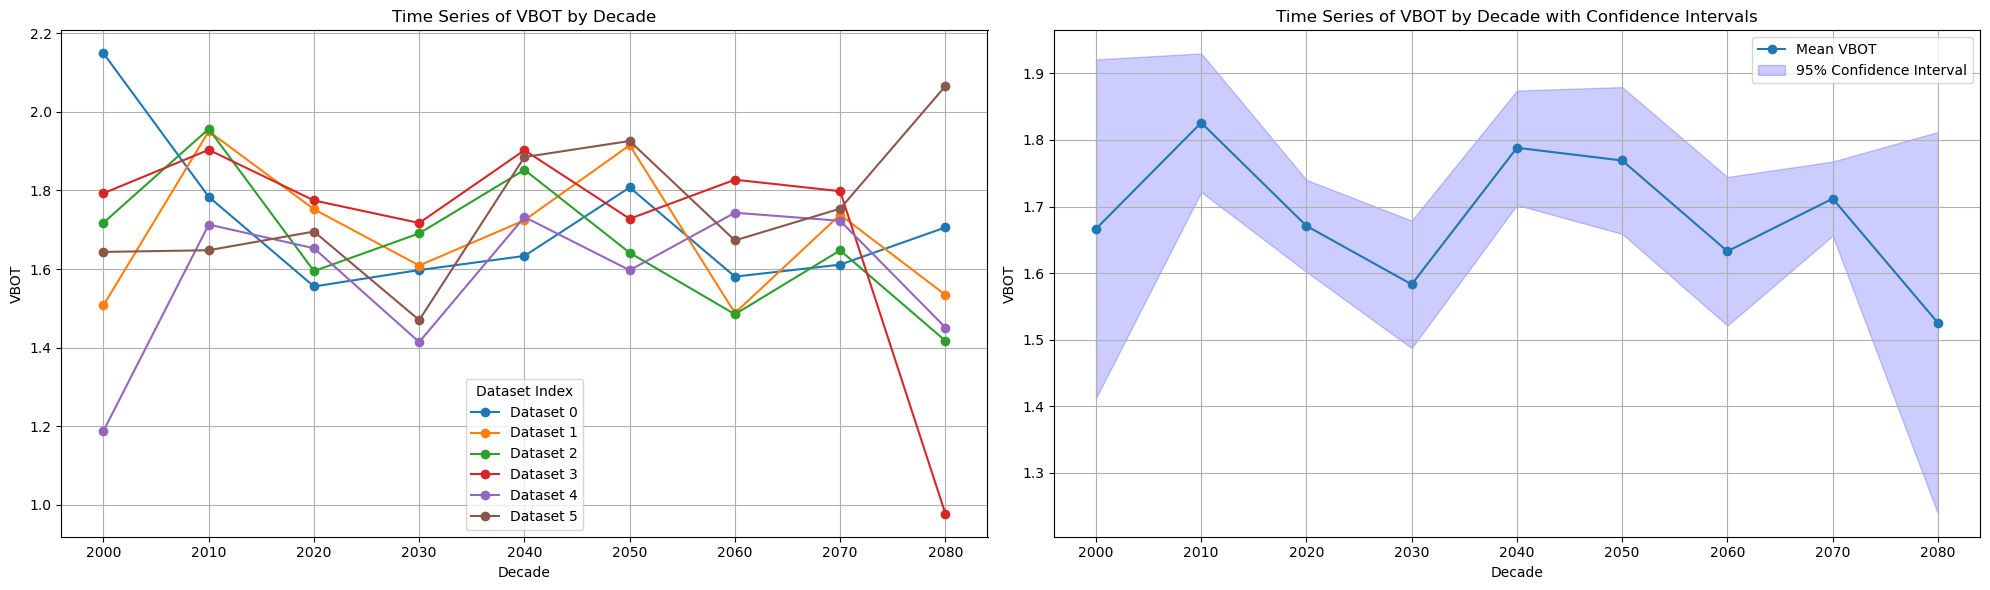

In [84]:
for attribute in attributes:
    print(attribute)
    # Prepare data
    ds_ts = ds[attribute].groupby(['decade', 'dataset_index']).mean()
    ds_ts = ds_ts.to_dataframe().reset_index()
    
    ds_ts = ds_ts.groupby(['decade', 'dataset_index'])[attribute].mean().reset_index()
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plotting the time series with legend by dataset_index on the first subplot
    for dataset_index in ds_ts['dataset_index'].unique():
        subset = ds_ts[ds_ts['dataset_index'] == dataset_index]
        axes[0].plot(subset['decade'], subset[attribute], marker='o', linestyle='-', label=f'Dataset {dataset_index}')
    axes[0].set_xlabel('Decade')
    axes[0].set_ylabel(attribute)
    axes[0].set_title(f'Time Series of {attribute} by Decade')
    axes[0].legend(title='Dataset Index')
    axes[0].grid(True)
    
    # Calculate mean and confidence intervals
    mean_ts = ds_ts.groupby('decade')[attribute].mean()
    conf_int = ds_ts.groupby('decade')[attribute].agg(lambda x: (x.mean() - 1.96 * x.std() / (len(x) ** 0.5), x.mean() + 1.96 * x.std() / (len(x) ** 0.5)))
    
    # Plotting the time series with confidence intervals on the second subplot
    axes[1].plot(mean_ts.index, mean_ts.values, marker='o', linestyle='-', label=f'Mean {attribute}')
    axes[1].fill_between(conf_int.index, conf_int.apply(lambda x: x[0]), conf_int.apply(lambda x: x[1]), color='b', alpha=0.2, label='95% Confidence Interval')
    axes[1].set_xlabel('Decade')
    axes[1].set_ylabel(attribute)
    axes[1].set_title(f'Time Series of {attribute} by Decade with Confidence Intervals')
    axes[1].legend()
    axes[1].grid(True)
    
    # Save figure
    plt.savefig('plots/time-series-of-variables-by-decade', dpi=800)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Variables such as QBOT, UBOT, FSNS, TREFHT, and TREFMXAV_U exhibit consistent growth over the projection period. Furthermore, some attributes appear less predictable and demonstrate higher variance across datasets throughout the series.

### 4.5 Deep-dive into Snowfall, Temperature, and Precipitation Changes

4.5.1 Snowfall

Time series of annual snowfall

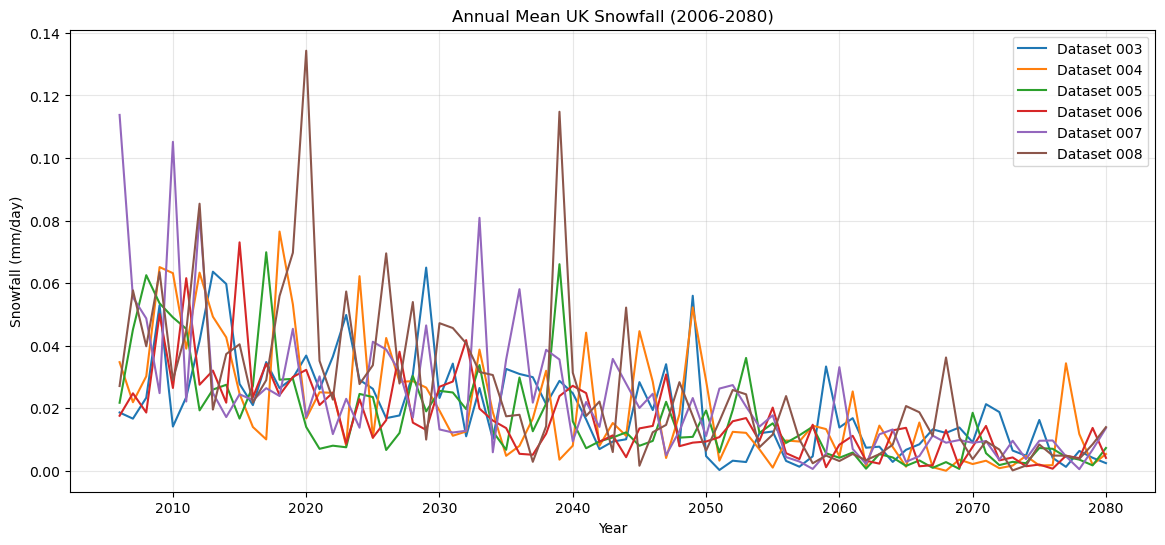

In [ ]:
plt.figure(figsize=(14, 6))

for i, ds in enumerate(datasets):
    # Calculate UK average snowfall
    uk_mean = ds.PRSN.mean(dim=['lat', 'lon']) * conversion_factor
    
    # Group by year
    annual_snow = uk_mean.groupby('time.year').mean()
    
    # Plot annual snowfall
    plt.plot(annual_snow['year'], annual_snow.squeeze(), label=f'Dataset {i+3:03d}')

plt.title('Annual Mean UK Snowfall (2006-2080)')
plt.xlabel('Year')
plt.ylabel('Snowfall (mm/day)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/annual-mean-uk-snowfall.png', dpi=300)
plt.show()

Seasonal Cycle Time series analysis for snow fall

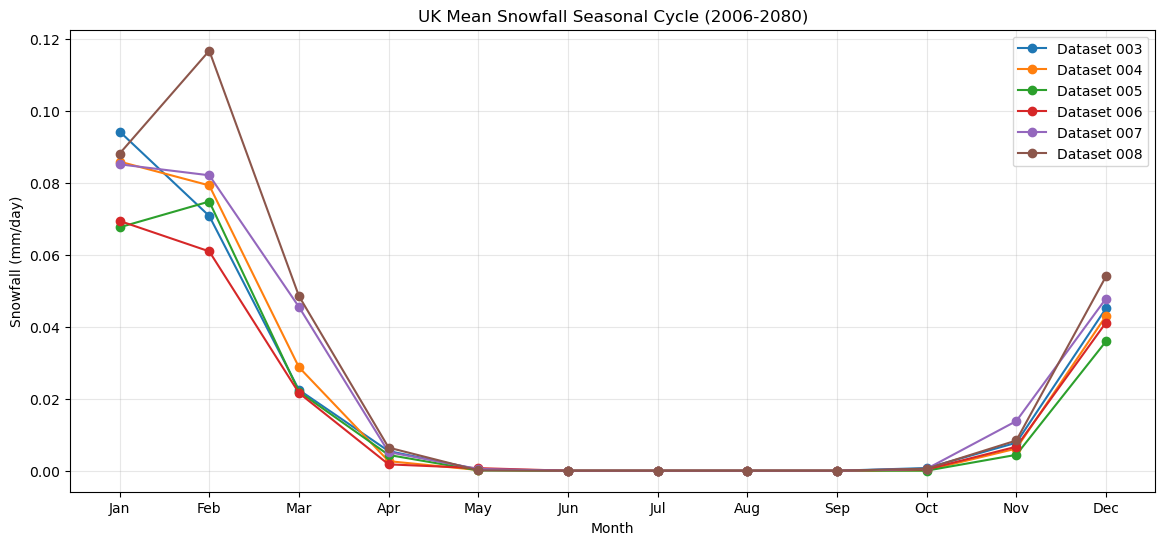

In [95]:
# Seasonal cycle of snowfall
plt.figure(figsize=(14, 6))

for i, ds in enumerate(datasets):
    # Calculate UK mean snowfall
    uk_mean = ds.PRSN.mean(dim=['lat', 'lon']) * conversion_factor
    
    # Group by month
    monthly_snow = uk_mean.groupby('time.month').mean()
    
    # Plot seasonal cycle
    plt.plot(monthly_snow['month'], monthly_snow.squeeze(), 'o-', label=f'Dataset {i+3:03d}')

plt.title('UK Mean Snowfall Seasonal Cycle (2006-2080)')
plt.xlabel('Month')
plt.ylabel('Snowfall (mm/day)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/uk-mean-snowfall-seasonal-cycle.png', dpi=300)
plt.show()

4.5.2 Temperature

Time series of mean annual Max Temperatures

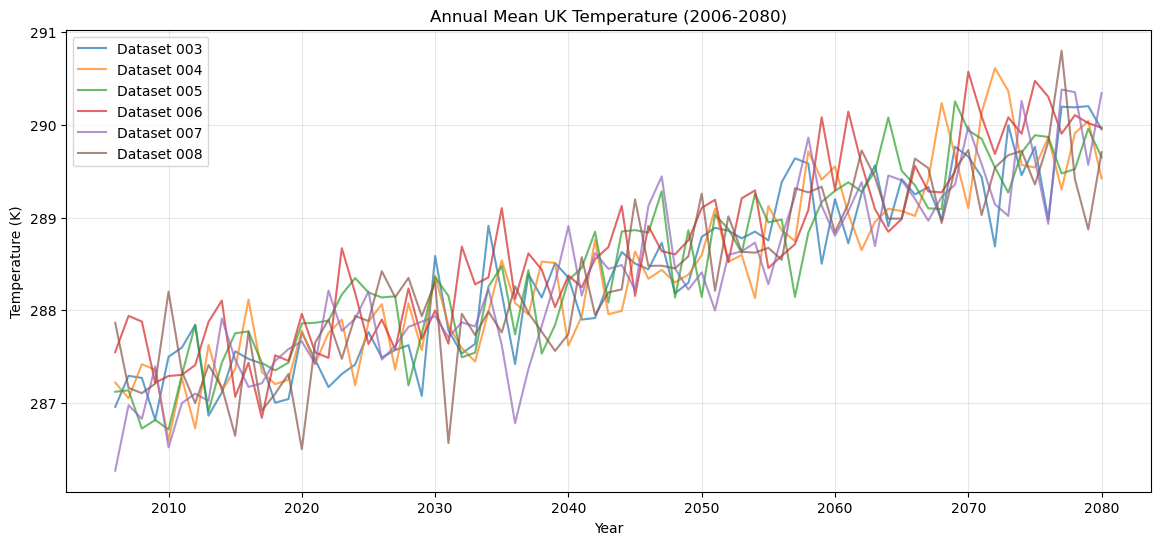

In [96]:
# Calculate UK average TREFMXAV_U by year
plt.figure(figsize=(14, 6))

for i, ds in enumerate(datasets):
    # Calculate spatial mean across all valid grid cells for each time step
    uk_mean = ds.TREFMXAV_U.mean(dim=['lat', 'lon'])
    
    # Group by year and calculate annual means
    annual_uk_means = uk_mean.groupby('time.year').mean()
    
    # Plot UK average annual temperature
    plt.plot(annual_uk_means.year, annual_uk_means.squeeze(), label=f'Dataset {i+3:03d}', alpha=0.7)

plt.title('Annual Mean UK Temperature (2006-2080)')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/annual-mean-uk-temperature.png', dpi=300)
plt.show()

Seasonal Cycle Time series analysis for Max Temperature

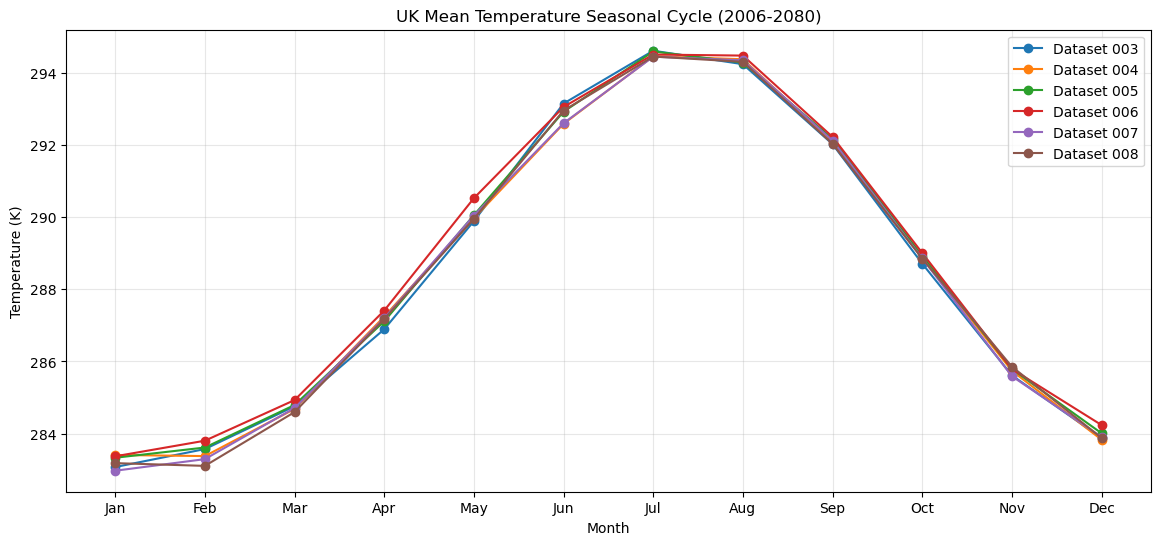

In [97]:
# Create a seasonal cycle plot
plt.figure(figsize=(14, 6))

for i, ds in enumerate(datasets):
    # Calculate UK mean
    uk_mean = ds.TREFMXAV_U.mean(dim=['lat', 'lon'])
    
    # Group by month and calculate climatology
    monthly_clim = uk_mean.groupby('time.month').mean()
    
    # Plot seasonal cycle
    plt.plot(monthly_clim.month, monthly_clim.squeeze(), 'o-', label=f'Dataset {i+3:03d}')

plt.title('UK Mean Temperature Seasonal Cycle (2006-2080)')
plt.xlabel('Month')
plt.ylabel('Temperature (K)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/uk-mean-temperature-seasonal-cycle.png', dpi=300)
plt.show()

4.5.3 Precipitation

Time series of mean annual Precipitation

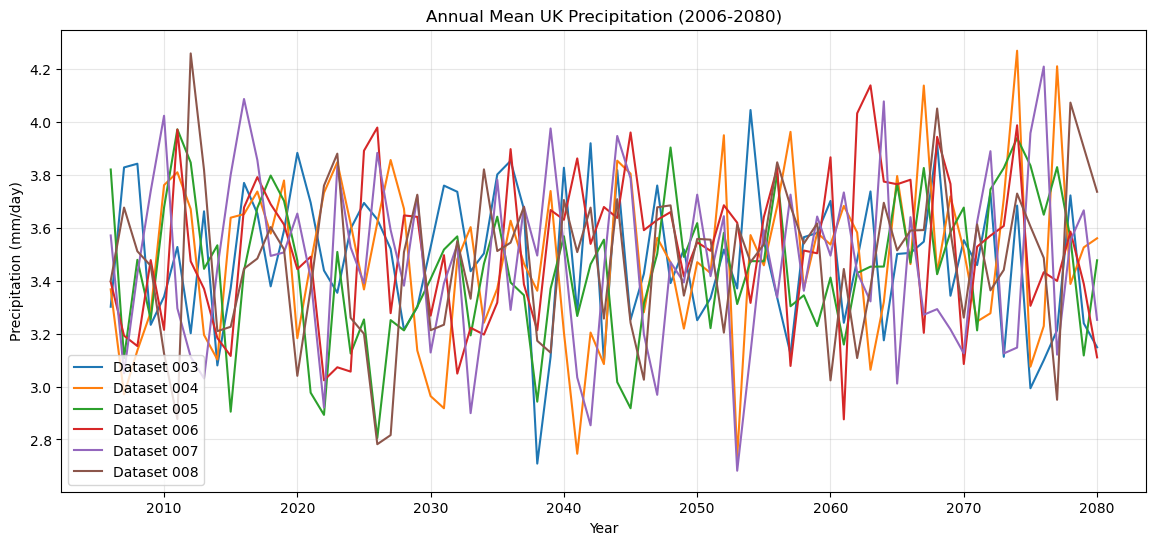

In [ ]:
# Time series of annual precipitation
plt.figure(figsize=(14, 6))

# PRECT is in m/s, so convert to mm/day for easier interpretation
conversion_factor = 86400 * 1000  # seconds in a day * 1000 to convert m to mm
# This therefore shows the average daily precipitation rate for each year

for i, ds in enumerate(datasets):
    # Calculate UK average precipitation
    uk_mean = ds.PRECT.mean(dim=['lat', 'lon']) * conversion_factor
    
    # Group by year
    annual_precip = uk_mean.groupby('time.year').mean()
    
    # Plot annual precipitation
    plt.plot(annual_precip.year, annual_precip.squeeze(), label=f'Dataset {i+3:03d}')

plt.title('Annual Mean UK Precipitation (2006-2080)')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/annual-mean-uk-precipitation.png', dpi=300)
plt.show()

Seasonal Cycle Time series analysis for Precipitation

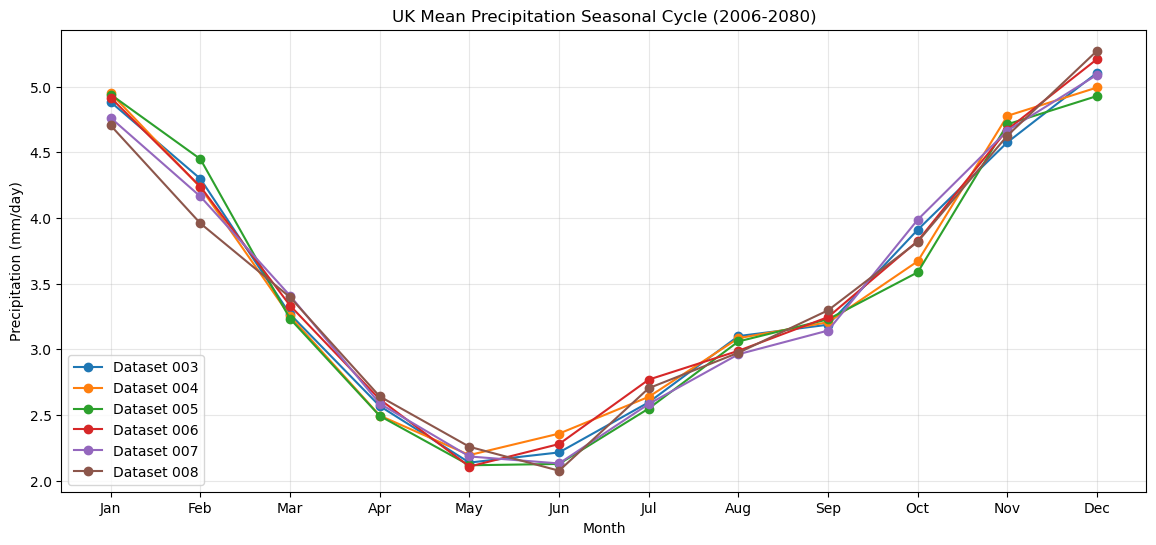

In [99]:
# Seasonal cycle of precipitation
plt.figure(figsize=(14, 6))

for i, ds in enumerate(datasets):
    # Calculate UK mean precipitation
    uk_mean = ds.PRECT.mean(dim=['lat', 'lon']) * conversion_factor
    
    # Group by month
    monthly_precip = uk_mean.groupby('time.month').mean()
    
    # Plot seasonal cycle
    plt.plot(monthly_precip['month'], monthly_precip.squeeze(), 'o-', label=f'Dataset {i+3:03d}')

plt.title('UK Mean Precipitation Seasonal Cycle (2006-2080)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm/day)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/uk-mean-precipitation-seasonal-cycle.png', dpi=300)
plt.show()